## 2. Thermal 이미지 처리
- 본 예제에서는 이미지 촬영 시 저장된 **.png 파일**과 **.npy 파일**을 이용하여 **식물 전체 영역**에 대한 **열화상 평균값**을 구하는 실습을 진행합니다. 총 2가지 실습으로 구성되어 있으며, 목차는 다음과 같습니다. 

>>> 2-1. 여러 개의 ROI를 지정한 후 평균값 추출

>>> 2-2. Segmentation 이후 평균값 추출

- 먼저 본 예제 파일과 같은 경로상에 분석을 원하는 **.png 파일**과 **.npy 파일**을 폴더에 추가하고 추후 코드에서 경로를 변경해주세요.

<hr>

### 2-1. 여러 개의 Roi를 지정한 후 평균값 추출

ROI 1 Temperature: 27.0°C
ROI 2 Temperature: 26.9°C
ROI 3 Temperature: 27.0°C
ROI 4 Temperature: 26.9°C
ROI 5 Temperature: 26.5°C


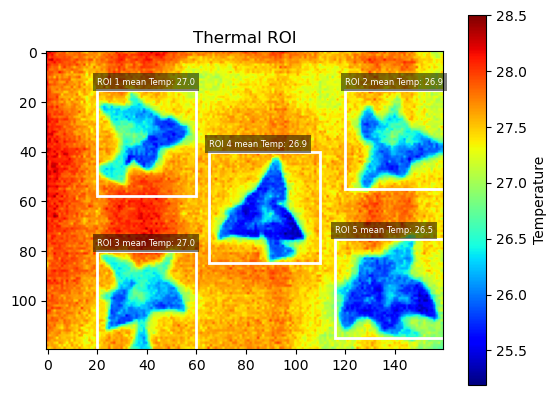

In [3]:
# 1. 라이브러리 import
# numpy: 수치 연산을 위한 라이브러리
# os: 파일 경로 관련 작업을 위한 라이브러리
# matplotlib.pyplot: 이미지를 시각화하는 데 사용되는 라이브러리
# PIL.Image: 이미지를 처리하기 위한 라이브러리
import numpy as np 
import os
import matplotlib.pyplot as plt
from PIL import Image

# 2. 열화상 데이터 불러오기
# npy 파일은 NumPy 배열 형태로 저장된 데이터 파일입니다. 열화상 이미지 데이터를 불러옵니다.
file_path = '../img_src/Thermal_Data/thermal_sample.npy'  # 분석할 열화상 데이터 파일 경로
thermal_data = np.load(file_path)  # 파일에서 열화상 데이터를 불러옵니다.

# 3. 온도 단위 변환
# 열화상 데이터는 켈빈(Kelvin) 단위로 저장되어 있으므로 이를 섭씨(Celsius)로 변환합니다.
def ktoc(val):
  return (val - 27315) / 100.0  # 27315를 빼고 100으로 나누어 섭씨로 변환

thermal_data = ktoc(thermal_data)  # 열화상 데이터를 섭씨로 변환
thermal_image_data = np.squeeze(thermal_data)  # 차원이 하나인 경우 이를 제거해 2D 배열로 변환

# 4. ROI(Region of Interest) 설정
# 사용자가 관심 있는 영역(ROI)을 직접 설정합니다. 각 ROI는 (x1, y1, x2, y2) 좌표로 정의됩니다.
rois = [
    (20, 15, 60, 58),    # ROI 1: 좌상단 (20, 15)에서 우하단 (60, 58)까지의 영역
    (120, 15, 160, 55),  # ROI 2: 좌상단 (120, 15)에서 우하단 (160, 55)까지의 영역
    (20, 80, 60, 120),   # ROI 3
    (65, 40, 110, 85),   # ROI 4
    (116, 75, 160, 115), # ROI 5
]

# 5. ROI 영역에 대해 평균 온도를 계산하고 시각적으로 표시
# 각 ROI 영역에 대해 해당 영역의 평균 온도를 계산한 후, 이를 이미지 위에 사각형과 텍스트로 표시합니다.
for i, (x1, y1, x2, y2) in enumerate(rois, start=1):
    # 지정한 ROI 영역에서 열화상 데이터를 추출합니다. y 범위가 먼저, 그다음 x 범위로 추출.
    roi = thermal_image_data[y1:y2, x1:x2]
    
    # 해당 ROI 영역의 평균 온도를 계산
    roi_mean = np.mean(roi)
    print(f"ROI {i} Temperature: {roi_mean:.1f}°C")  # 소수점 첫째 자리까지 출력
    
    # 이미지에 사각형으로 ROI 영역을 표시
    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='white', facecolor='none', linewidth=2)
    plt.gca().add_patch(rect)  # 사각형을 이미지에 추가
    
    # ROI 영역의 평균 온도를 텍스트로 표시
    plt.text(x1, y1 - 5, f'ROI {i} mean Temp: {roi_mean:.1f}', color='white', fontsize=6, ha='left', va='top',
             bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', pad=3))  # 텍스트 스타일 설정

# 6. 열화상 이미지 표시
# 열화상 이미지를 컬러맵 'jet'으로 시각화하고, 온도를 나타내는 색상 바를 추가
plt.imshow(thermal_image_data, cmap='jet')  # 'jet' 컬러맵을 사용하여 열화상 이미지 표시
plt.colorbar(label='Temperature')  # 색상 바 추가 (온도 값)
plt.title('Thermal ROI')  # 이미지 제목 설정

# 7. 이미지 출력
plt.show()  # 설정된 이미지를 화면에 표시


<hr>

### 2-2. Segmentation 이후 평균값 추출
- 두번째 예제에서는 Segment anything 2 (SAM2) 모델을 이용하여 배경과 식물을 분리하고, 평균값을 추출하는 예제를 진행합니다. 

- Windows 환경에서는 WSL (Windows Subsystem for Linux) 환경을 이용하시는 것을 강력하게 추천합니다.

- 앞서 Readme 파일에 맞춰 환경설정과 모델 checkpoints 다운로드가 완료되었다고 가정하고 진행하겠습니다.

- SAM2 모델을 git clone 하는 위치는 './FINAL_RDA_DRILL/segment-anything-2'와 같이 바로 하위 폴더에 받으면 됩니다.

In [ ]:
## 1. 라이브러리 import 및 함수 선언

import random # 난수 생성을 위한 라이브러리
import numpy as np  # 수치 연산을 위한 라이브러리
import pandas as pd  # 데이터 처리 및 분석을 위한 라이브러리
import cv2  # 이미지 처리 라이브러리
import torch  # 딥러닝 모델을 위한 라이브러리
import csv  # CSV 파일 읽기 및 쓰기
import matplotlib.pyplot as plt  # 데이터 시각화 라이브러리
from PIL import Image  # 이미지 처리 라이브러리
from sam2.build_sam import build_sam2  # SAM2 모델 빌드 함수
from sam2.sam2_image_predictor import SAM2ImagePredictor  # SAM2 이미지 예측 함수
from hydra import initialize, compose # 설정 파일을 읽기 위한 라이브러리
from omegaconf import OmegaConf  # 설정 파일을 읽기 위한 라이브러리

 # 난수 시드 설정
seed = 69
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True



## 2. 마스크 표시 함수

# show_mask 함수는 이미지에서 분할된 마스크를 표시하는 역할을 합니다.
# 마스크는 식물의 영역을 나타내며, 색상과 경계선을 설정할 수 있습니다.
def show_mask(mask, ax, random_color=False, borders=True):
    # 마스크의 색상을 무작위로 설정할지 여부를 결정합니다.
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)  # 임의의 색상 생성
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])  # 기본 색상(파란색)
    
    # 마스크의 크기와 형식을 설정합니다.
    h, w = mask.shape[-2:]  # 마스크의 높이와 너비
    mask = mask.astype(np.uint8)  # 마스크를 정수형으로 변환
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)  # 마스크 이미지 생성
    
    # 경계선을 그릴지 여부를 결정합니다.
    if borders:
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)  # 마스크의 경계선 찾기
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]  # 경계선 다듬기
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)  # 경계선 그리기
    ax.imshow(mask_image)  # 마스크 이미지를 화면에 표시



## 3. 좌표점 표시 함수

# show_points 함수는 이미지 상에서 식물 영역을 표시할 좌표점들을 그립니다.
# 좌표점은 식물의 위치를 나타내며, 초록색은 긍정 점, 빨간색은 부정 점을 의미합니다.
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]  # 긍정 좌표(식물 위치)
    neg_points = coords[labels == 0]  # 부정 좌표(배경 위치)
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, 
               edgecolor='white', linewidth=1.25)  # 초록색 별표로 긍정 좌표 표시
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, 
               edgecolor='white', linewidth=1.25)  # 빨간색 별표로 부정 좌표 표시



## 4. 박스(영역) 표시 함수

# show_box 함수는 이미지에서 식물 영역을 사각형 박스로 표시합니다.
def show_box(box, ax):
    x0, y0 = box[0], box[1]  # 박스의 좌상단 좌표
    w, h = box[2] - box[0], box[3] - box[1]  # 박스의 너비와 높이
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))  # 박스를 화면에 그리기



## 5. 마스크, 좌표, 박스를 모두 포함한 이미지 표시 함수

# show_masks 함수는 분할된 식물 영역(마스크), 좌표점, 박스 등을 모두 포함한 이미지를 표시합니다.
def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):  # 각 마스크와 그에 대응하는 점수 처리
        plt.figure(figsize=(10, 10))
        plt.imshow(image)  # 원본 이미지를 표시
        show_mask(mask, plt.gca(), borders=borders)  # 마스크를 표시
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())  # 좌표점을 표시
        if box_coords is not None:
            show_box(box_coords, plt.gca())  # 박스를 표시
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)  # 마스크와 점수 표시
        plt.axis('off')  # 축 숨기기
        plt.show()  # 이미지를 화면에 표시

### Model 설정

In [ ]:
# 체크포인트 및 설정 파일 경로
checkpoint = "../segment-anything-2/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

# SAM2 이미지 예측기 생성
predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint, device='cpu'))


# 분석할 이미지 경로
image_path = "../img_src/Thermal_Data/thermal_image.png"

# 이미지 불러오기
image = Image.open(image_path).convert("RGB")

# 이미지 배열 변환
image = np.array(image)

# SAM2 예측기에 이미지 설정
predictor.set_image(image)

### 사용자가 분석할 이미지가 맞는지 확인하는 부분입니다.

In [ ]:
# 이미지를 화면에 출력하여 사용자가 선택한 이미지가 맞는지 시각적으로 확인할 수 있습니다.
plt.figure(figsize=(10, 10))  # 출력할 이미지의 크기를 설정합니다.
plt.imshow(image)  # 이미지를 화면에 표시
plt.axis('on')  # 축을 켜서 좌표 값을 확인할 수 있도록 설정
plt.show()  # 이미지를 화면에 출력

### 마스킹할 영역 설정

In [ ]:
# 1. 마스킹할 영역의 좌표를 설정
# input_point 변수에 사용자가 마스킹을 원하는 영역의 좌표를 설정합니다.
# 좌표는 [x, y] 형식이며, 여기서는 5개의 포인트가 지정되어 있습니다.
input_point = np.array([[40, 30], [36, 90], [80, 65], [140, 30], [140, 90]])

# 2. 마스킹 여부 설정
# input_label 변수는 각 좌표에 대해 마스킹할지 여부를 지정합니다.
# '1'은 마스킹할 영역을 의미하고, '0'은 마스킹에서 제외할 영역을 의미합니다.
# 각 input_point에 대응하는 값이 있어야 하며, input_point의 갯수와 input_label의 숫자가 동일해야 합니다.
input_label = np.array([1, 1, 1, 1, 1])

# 3. 마스킹 설정을 시각화
# 지정한 좌표를 화면에 시각화하여 사용자가 설정한 영역을 확인합니다.
# 초록색 별은 마스킹할 영역을 나타내고, 빨간색 별은 마스킹에서 제외할 영역을 나타냅니다.
plt.figure(figsize=(10, 10))  # 이미지의 크기를 설정
plt.imshow(image)  # 이미지를 화면에 표시
show_points(input_point, input_label, plt.gca())  # 지정한 좌표를 표시 (초록색 또는 빨간색 별로 시각화)
plt.axis('on')  # 좌표 축을 켬
plt.show()  # 이미지를 화면에 출력

### 마스킹된 영역에 대한 결과 이미지를 확인

In [ ]:
# 이 코드는 지정된 마스킹 영역이 원하는 대로 포함되었는지 확인하는 과정입니다.
# 사용자는 'input_point'의 좌표를 조정하여 원하는 영역을 수정할 수 있습니다.

# SAM2 모델에서 생성된 이미지의 임베딩 크기 확인
# 이미지 임베딩(특징 벡터)의 모양을 출력하여 모델이 이미지를 올바르게 처리했는지 확인합니다.
print(predictor._features['image_embed'].shape, predictor._features['image_embed'][-1].shape)

# SAM2 모델을 이용한 마스크 생성
# predictor.predict 함수를 사용하여 지정된 좌표(input_point)와 레이블(input_label)을 기반으로 이미지를 분할합니다.
# multimask_output=False: 다중 마스크가 아닌 단일 마스크 결과를 출력
masks, scores, logits = predictor.predict(
    point_coords=input_point,  # 마스킹할 좌표
    point_labels=input_label,  # 마스킹 여부를 나타내는 레이블
    multimask_output=False,  # 여러 마스크가 아닌 하나의 마스크만 출력
)

# 마스크의 점수를 기준으로 정렬 (높은 점수 순서로 정렬)
sorted_ind = np.argsort(scores)[::-1]  # 점수를 기준으로 내림차순 정렬
masks = masks[sorted_ind]  # 마스크도 점수 순서대로 정렬
scores = scores[sorted_ind]  # 점수도 정렬
logits = logits[sorted_ind]  # logits도 정렬

# 결과 마스크를 시각적으로 확인
# 지정된 영역에 대해 마스킹된 결과를 이미지로 표시합니다.
show_masks(
    image,  # 원본 이미지
    masks,  # 마스킹된 이미지 결과
    scores,  # 마스킹된 영역의 점수
    point_coords=input_point,  # 마스킹할 좌표
    input_labels=input_label,  # 마스킹 여부
    borders=True  # 마스크 경계선 표시
)

### 마스킹된 영역의 좌표 정보를 DataFrame에 저장

In [ ]:
# 마스킹된 이미지에서 2D 마스크를 추출합니다. 마스크는 3D 배열이므로 첫 번째 축을 제거하여 2D로 만듭니다.
masks_2d = np.squeeze(masks, axis=0)

# 마스킹된 2D 배열을 Pandas DataFrame으로 변환합니다.
df_masks = pd.DataFrame(masks_2d)

# DataFrame의 크기와 첫 몇 줄을 출력하여 올바르게 변환되었는지 확인합니다.
print(df_masks.shape)  # DataFrame의 행과 열 크기를 출력
print(df_masks.head())  # DataFrame의 상위 5개 행을 출력

# '1'의 개수 구하기
# '1'은 마스크 영역을 의미하며, '0'은 배경을 의미합니다.
# np.sum() 함수를 사용하여 마스크 영역('1')의 개수를 계산합니다.
num_ones_2 = np.sum(masks_2d == 1)

# 마스크에서 '1'의 개수를 출력합니다.
print(f"마스크에서 '1'의 개수: {num_ones_2}")

# 마스크에서 값이 '1'인 요소(마스킹된 영역)의 x, y 좌표를 구합니다.
# DataFrame의 stack() 메소드를 사용하여 좌표 정보를 얻고, '1'인 값만 필터링합니다.
coordinates = df_masks.stack().reset_index()  # 다차원 배열을 2차원으로 변환하고 인덱스를 초기화
coordinates.columns = ['y', 'x', 'value']  # 열 이름을 'y', 'x', 'value'로 설정
coordinates = coordinates[coordinates['value'] == 1]  # 값이 '1'인 좌표만 선택
coordinates = coordinates[['x', 'y']]  # 'x', 'y' 좌표만 남김

# 좌표의 상위 5개 행을 출력하여 확인합니다.
print(coordinates.head()) 

# 마스킹된 영역의 좌표를 CSV 파일로 저장
# 좌표 정보를 CSV 파일로 저장하며, 원하는 파일 이름으로 저장할 수 있습니다.
coordinates.to_csv('../results/Thermal/mask_thermal_sample.csv', index=False)  # 인덱스는 저장하지 않음

In [ ]:
# 2-1에서 켈빈온도를 섭씨온도로 바꾼 데이터를 불러옵니다.
thermal_df = pd.DataFrame(thermal_image_data)
thermal_df

In [ ]:
# 2-1에서 변환된 섭씨 온도 데이터를 불러옵니다.
# thermal_image_data는 2-1에서 켈빈 온도를 섭씨로 변환한 열화상 데이터입니다.
thermal_df = pd.DataFrame(thermal_image_data)  # 열화상 데이터를 DataFrame으로 변환하여 사용합니다.
thermal_df.head()  # 열화상 데이터의 상위 5개 행을 확인합니다.

# 마스킹 영역의 좌표와 열화상 데이터에서 해당 좌표의 온도 값을 추출
# 'mask_thermal_sample.csv'는 2-2에서 저장된 마스킹된 영역의 좌표를 저장한 파일입니다.
# 사용자는 파일명을 본인의 파일명에 맞게 수정해야 합니다.
coordinates_df = pd.read_csv('../results/Thermal/mask_thermal_sample.csv')  # 마스킹된 좌표 데이터를 불러옵니다.

# 열화상 데이터의 크기를 확인하여 마스킹 좌표가 유효한지 검사
max_x = thermal_df.shape[1] - 1  # 열화상 데이터의 최대 x 좌표 (열 개수 - 1)
max_y = thermal_df.shape[0] - 1  # 열화상 데이터의 최대 y 좌표 (행 개수 - 1)

# 마스킹된 좌표가 유효한 범위에 있는지 필터링 (x 좌표와 y 좌표가 열화상 데이터 범위 내에 있는지 확인)
valid_coords = coordinates_df[(coordinates_df['x'] <= max_x) & (coordinates_df['y'] <= max_y)]

# 마스킹된 영역의 각 좌표에 해당하는 열화상 데이터를 추출
values = []
for index, row in valid_coords.iterrows():  # 유효한 좌표에 대해 반복
    x, y = int(row['x']), int(row['y'])  # 각 좌표의 x, y 값을 추출
    value = thermal_df.iloc[y, x]  # 열화상 데이터에서 해당 좌표의 온도 값을 추출
    values.append({'x': x, 'y': y, 'value': value})  # 좌표와 값을 딕셔너리 형태로 리스트에 저장

# 추출한 좌표와 값을 DataFrame으로 변환
extracted_df = pd.DataFrame(values)

# 추출된 좌표와 온도 값의 상위 5개 행을 출력하여 확인
print(extracted_df.head())

# 추출된 좌표와 온도 데이터를 CSV 파일로 저장
# 'mask_thermal_sample_fin.csv' 파일로 저장하며, 파일명은 원하는 이름으로 변경 가능합니다.
extracted_df.to_csv('../results/Thermal/mask_thermal_sample_fin.csv', index=False)  # 인덱스 없이 CSV로 저장
print("'mask_thermal_sample_fin.csv'에 저장되었습니다.")  # 저장 완료 메시지 출력


### 마스킹 영역에 대한 온도 평균값

In [ ]:
# masking 영역에 대한 평균값은 다음과 같습니다. 
extracted_df['value'].mean()